<a href="https://colab.research.google.com/github/WatanabeRyusuke/automated-build/blob/master/DCGAN_mnist_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

import numpy as np
import math
import matplotlib.pyplot as plt
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import Activation, BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Model
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

In [0]:
%matplotlib inline

In [0]:
def build_generator(inputs, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)
    
    for filters in layer_filters:
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                                                kernel_size=kernel_size,
                                                strides=strides,
                                                padding='same')(x)
    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    return generator

In [0]:
def build_discriminator(inputs):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    
    for filters in layer_filters:
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                              kernel_size=kernel_size,
                              strides=strides,
                              padding='same')(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator

In [0]:
def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):

    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

In [0]:
def train(models, x_train, params):
    generator, discriminator, adversarial = models
    batch_size, latent_size, train_steps, model_name = params
    save_interval = 500
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    train_size = x_train.shape[0]

    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_images = generator.predict(noise)
        x = np.concatenate((real_images, fake_images))
        y = np.ones([2*batch_size, 1])
        y[batch_size: , :] = 0.0
        loss, acc = discriminator.train_on_batch(x, y)
        log = '%d: [discriminator loss: %f, acc: %f]' % (i, loss, acc)
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])
        loss, acc = adversarial.train_on_batch(noise, y)
        log = '%s [adversarial loss: %f, acc: %f]' % (log, loss, acc)
        if (i + 1) % save_interval == 0:
            print(log)
            plot_images(generator,
                                  noise_input=noise_input,
                                  show=True,
                                  step=(i + 1),
                                  model_name=model_name)

    generator.save(model_name + '.h5')

In [0]:
def build_and_train_model():
    (x_train, _), (_, _) = mnist.load_data()
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255
    model_name = 'dcgan_mnist'
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                                          optimizer=optimizer,
                                          metrics=['accuracy'])
    discriminator.summary()

    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    discriminator.trainable = False 
    adversarial = Model(inputs,
                                       discriminator(generator(inputs)),
                                       name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                                      optimizer=optimizer,
                                      metrics=['accuracy'])
    adversarial.summary()
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train, params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 128)         204928    
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


499: [discriminator loss: 0.511570, acc: 0.781250] [adversarial loss: 1.040422, acc: 0.093750]


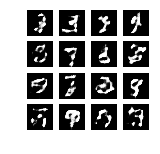

999: [discriminator loss: 0.477632, acc: 0.789062] [adversarial loss: 1.027175, acc: 0.312500]


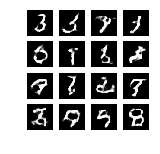

1499: [discriminator loss: 0.511754, acc: 0.718750] [adversarial loss: 0.547200, acc: 0.656250]


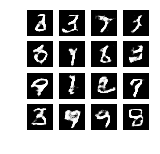

1999: [discriminator loss: 0.483097, acc: 0.765625] [adversarial loss: 1.140429, acc: 0.296875]


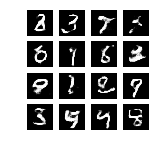

2499: [discriminator loss: 0.556433, acc: 0.718750] [adversarial loss: 1.237519, acc: 0.312500]


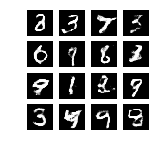

2999: [discriminator loss: 0.638983, acc: 0.656250] [adversarial loss: 1.832318, acc: 0.093750]


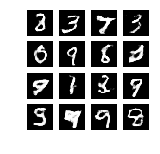

3499: [discriminator loss: 0.518979, acc: 0.734375] [adversarial loss: 1.368533, acc: 0.218750]


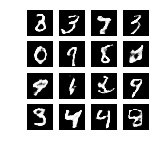

3999: [discriminator loss: 0.564855, acc: 0.718750] [adversarial loss: 1.754194, acc: 0.046875]


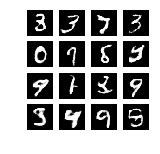

4499: [discriminator loss: 0.436447, acc: 0.789062] [adversarial loss: 1.623634, acc: 0.062500]


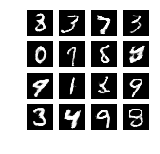

4999: [discriminator loss: 0.468189, acc: 0.734375] [adversarial loss: 0.979792, acc: 0.359375]


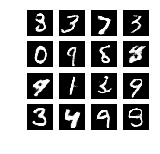

5499: [discriminator loss: 0.533046, acc: 0.750000] [adversarial loss: 1.153415, acc: 0.281250]


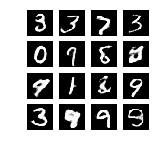

5999: [discriminator loss: 0.567376, acc: 0.718750] [adversarial loss: 1.223268, acc: 0.250000]


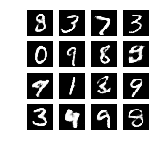

6499: [discriminator loss: 0.519995, acc: 0.750000] [adversarial loss: 1.346328, acc: 0.203125]


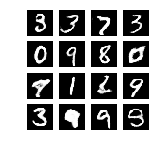

6999: [discriminator loss: 0.474599, acc: 0.781250] [adversarial loss: 1.169853, acc: 0.187500]


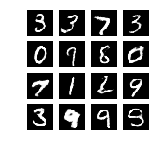

7499: [discriminator loss: 0.529808, acc: 0.695312] [adversarial loss: 1.339625, acc: 0.140625]


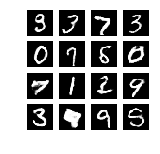

7999: [discriminator loss: 0.592506, acc: 0.703125] [adversarial loss: 1.062908, acc: 0.343750]


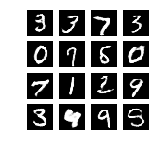

8499: [discriminator loss: 0.613167, acc: 0.671875] [adversarial loss: 1.041284, acc: 0.328125]


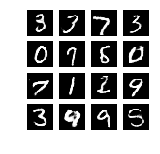

8999: [discriminator loss: 0.549369, acc: 0.710938] [adversarial loss: 1.128652, acc: 0.250000]


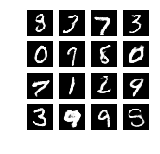

9499: [discriminator loss: 0.499817, acc: 0.750000] [adversarial loss: 1.324101, acc: 0.187500]


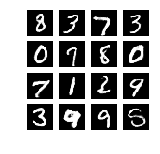

9999: [discriminator loss: 0.506690, acc: 0.726562] [adversarial loss: 0.989468, acc: 0.421875]


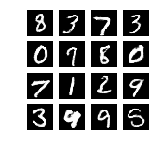

10499: [discriminator loss: 0.625716, acc: 0.656250] [adversarial loss: 0.953928, acc: 0.296875]


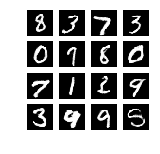

10999: [discriminator loss: 0.567423, acc: 0.718750] [adversarial loss: 0.691448, acc: 0.609375]


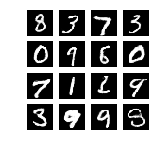

11499: [discriminator loss: 0.513917, acc: 0.750000] [adversarial loss: 1.041727, acc: 0.312500]


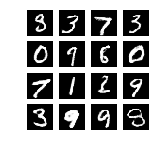

11999: [discriminator loss: 0.545007, acc: 0.742188] [adversarial loss: 1.676587, acc: 0.031250]


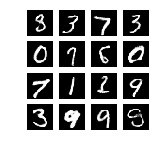

12499: [discriminator loss: 0.580618, acc: 0.687500] [adversarial loss: 0.959696, acc: 0.421875]


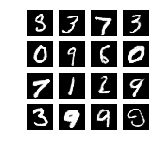

12999: [discriminator loss: 0.611701, acc: 0.648438] [adversarial loss: 0.951849, acc: 0.406250]


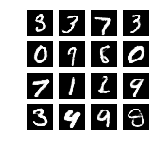

13499: [discriminator loss: 0.525467, acc: 0.718750] [adversarial loss: 1.174056, acc: 0.281250]


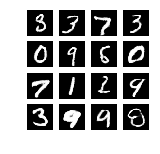

13999: [discriminator loss: 0.581553, acc: 0.671875] [adversarial loss: 0.996810, acc: 0.359375]


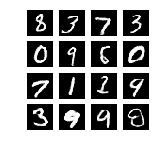

14499: [discriminator loss: 0.660070, acc: 0.648438] [adversarial loss: 1.497005, acc: 0.125000]


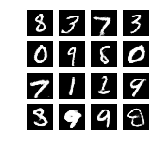

14999: [discriminator loss: 0.572483, acc: 0.687500] [adversarial loss: 1.169203, acc: 0.265625]


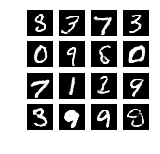

15499: [discriminator loss: 0.575764, acc: 0.710938] [adversarial loss: 0.768566, acc: 0.468750]


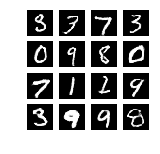

15999: [discriminator loss: 0.513332, acc: 0.718750] [adversarial loss: 1.129185, acc: 0.265625]


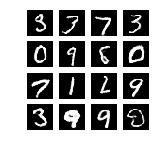

16499: [discriminator loss: 0.540357, acc: 0.703125] [adversarial loss: 0.944930, acc: 0.296875]


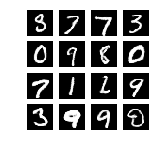

16999: [discriminator loss: 0.500758, acc: 0.742188] [adversarial loss: 1.318395, acc: 0.156250]


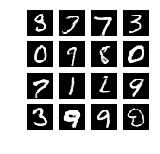

17499: [discriminator loss: 0.489223, acc: 0.765625] [adversarial loss: 1.040983, acc: 0.281250]


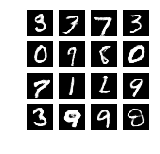

17999: [discriminator loss: 0.607481, acc: 0.601562] [adversarial loss: 1.224972, acc: 0.250000]


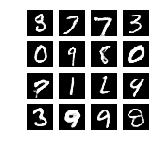

18499: [discriminator loss: 0.577397, acc: 0.656250] [adversarial loss: 1.293019, acc: 0.187500]


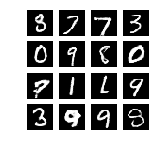

18999: [discriminator loss: 0.620402, acc: 0.625000] [adversarial loss: 1.145718, acc: 0.296875]


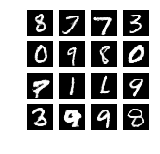

19499: [discriminator loss: 0.536403, acc: 0.671875] [adversarial loss: 0.735908, acc: 0.578125]


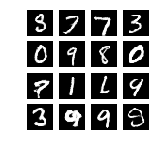

19999: [discriminator loss: 0.511084, acc: 0.757812] [adversarial loss: 1.617503, acc: 0.140625]


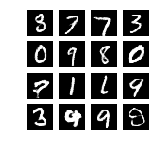

20499: [discriminator loss: 0.575226, acc: 0.718750] [adversarial loss: 1.319754, acc: 0.218750]


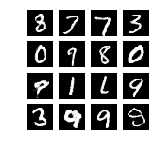

20999: [discriminator loss: 0.549127, acc: 0.687500] [adversarial loss: 1.611545, acc: 0.062500]


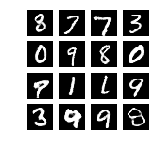

21499: [discriminator loss: 0.570254, acc: 0.695312] [adversarial loss: 1.105140, acc: 0.234375]


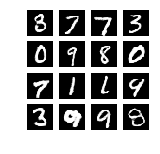

21999: [discriminator loss: 0.489493, acc: 0.773438] [adversarial loss: 1.304996, acc: 0.218750]


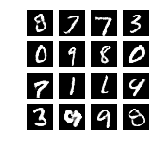

22499: [discriminator loss: 0.554866, acc: 0.726562] [adversarial loss: 1.700150, acc: 0.093750]


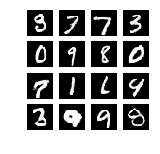

22999: [discriminator loss: 0.576541, acc: 0.726562] [adversarial loss: 1.675542, acc: 0.093750]


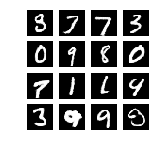

23499: [discriminator loss: 0.525698, acc: 0.750000] [adversarial loss: 1.169853, acc: 0.234375]


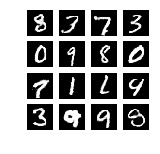

23999: [discriminator loss: 0.480384, acc: 0.773438] [adversarial loss: 1.397183, acc: 0.203125]


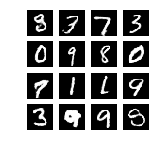

24499: [discriminator loss: 0.466540, acc: 0.757812] [adversarial loss: 1.122601, acc: 0.296875]


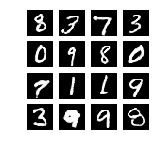

24999: [discriminator loss: 0.526592, acc: 0.734375] [adversarial loss: 0.873796, acc: 0.562500]


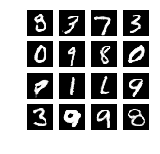

25499: [discriminator loss: 0.584587, acc: 0.656250] [adversarial loss: 1.429186, acc: 0.203125]


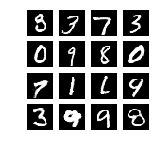

25999: [discriminator loss: 0.598450, acc: 0.656250] [adversarial loss: 0.577966, acc: 0.718750]


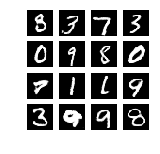

26499: [discriminator loss: 0.532137, acc: 0.710938] [adversarial loss: 1.757470, acc: 0.078125]


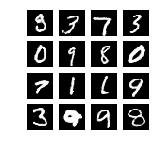

26999: [discriminator loss: 0.502185, acc: 0.773438] [adversarial loss: 1.020992, acc: 0.296875]


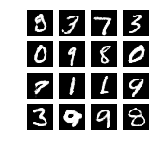

27499: [discriminator loss: 0.530522, acc: 0.710938] [adversarial loss: 1.007121, acc: 0.406250]


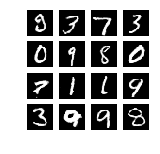

27999: [discriminator loss: 0.512277, acc: 0.726562] [adversarial loss: 1.602093, acc: 0.109375]


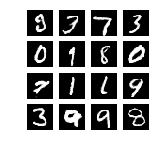

28499: [discriminator loss: 0.490267, acc: 0.789062] [adversarial loss: 1.342525, acc: 0.234375]


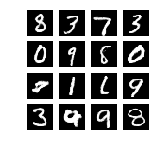

28999: [discriminator loss: 0.528403, acc: 0.718750] [adversarial loss: 0.999241, acc: 0.359375]


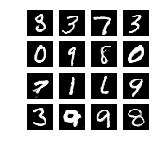

29499: [discriminator loss: 0.561622, acc: 0.734375] [adversarial loss: 1.525396, acc: 0.140625]


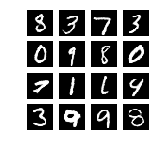

29999: [discriminator loss: 0.547721, acc: 0.695312] [adversarial loss: 1.173425, acc: 0.328125]


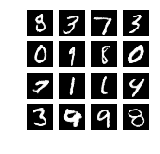

30499: [discriminator loss: 0.587217, acc: 0.679688] [adversarial loss: 1.665190, acc: 0.109375]


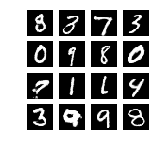

30999: [discriminator loss: 0.548567, acc: 0.718750] [adversarial loss: 1.199015, acc: 0.281250]


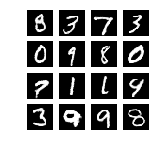

31499: [discriminator loss: 0.521296, acc: 0.718750] [adversarial loss: 1.040130, acc: 0.406250]


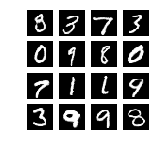

31999: [discriminator loss: 0.443715, acc: 0.796875] [adversarial loss: 1.025120, acc: 0.343750]


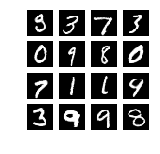

32499: [discriminator loss: 0.491832, acc: 0.765625] [adversarial loss: 1.038010, acc: 0.375000]


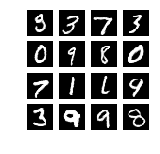

32999: [discriminator loss: 0.519989, acc: 0.804688] [adversarial loss: 1.422861, acc: 0.187500]


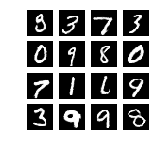

33499: [discriminator loss: 0.520043, acc: 0.765625] [adversarial loss: 1.121575, acc: 0.312500]


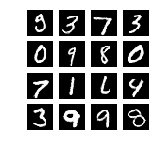

33999: [discriminator loss: 0.457667, acc: 0.804688] [adversarial loss: 1.066283, acc: 0.406250]


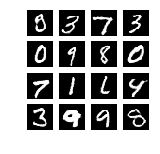

34499: [discriminator loss: 0.500508, acc: 0.757812] [adversarial loss: 1.756953, acc: 0.109375]


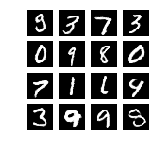

34999: [discriminator loss: 0.540879, acc: 0.734375] [adversarial loss: 1.324019, acc: 0.234375]


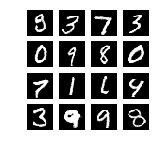

35499: [discriminator loss: 0.476998, acc: 0.789062] [adversarial loss: 1.202251, acc: 0.265625]


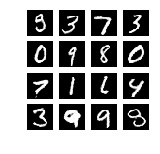

35999: [discriminator loss: 0.526177, acc: 0.703125] [adversarial loss: 1.636315, acc: 0.156250]


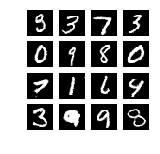

36499: [discriminator loss: 0.514717, acc: 0.750000] [adversarial loss: 1.529238, acc: 0.093750]


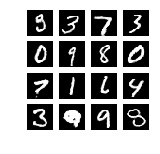

36999: [discriminator loss: 0.603273, acc: 0.687500] [adversarial loss: 0.857054, acc: 0.484375]


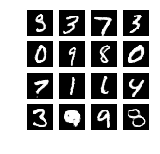

37499: [discriminator loss: 0.527536, acc: 0.718750] [adversarial loss: 0.934243, acc: 0.484375]


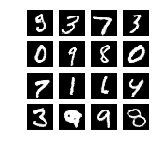

37999: [discriminator loss: 0.456127, acc: 0.812500] [adversarial loss: 1.245927, acc: 0.343750]


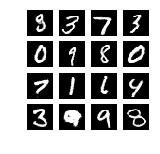

38499: [discriminator loss: 0.496417, acc: 0.734375] [adversarial loss: 1.683830, acc: 0.125000]


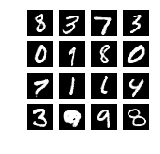

38999: [discriminator loss: 0.426973, acc: 0.804688] [adversarial loss: 1.055645, acc: 0.421875]


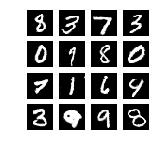

39499: [discriminator loss: 0.480370, acc: 0.750000] [adversarial loss: 1.375170, acc: 0.359375]


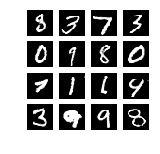

39999: [discriminator loss: 0.524389, acc: 0.742188] [adversarial loss: 1.567090, acc: 0.156250]


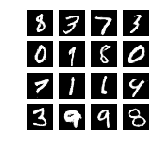

In [28]:
build_and_train_model()